### Preliminary Analysis

In [31]:
import sqlite3 as sql_client
import pandas as data_analyzer
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import colorcet as cc
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, LogColorMapper
from collections import defaultdict 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
SQL_DB_FILE_PATH='../FPA_FOD_20170508.sqlite'

causes_map = {
  'Miscellaneous': 0,
  'Lightning': 1,
  'Debris Burning': 2,
  'Campfire': 3,
  'Equipment Use': 4,
  'Arson': 5,
  'Children': 6,
  'Railroad': 7,
  'Smoking': 8,
  'Powerline': 9,
  'Structure': 10,
  'Fireworks': 11,
  'Missing/Undefined': 12
}


In [5]:
def set_causes_map(data_frame, description):
    '''
    This function takes in a dictionary and sets the causes
    '''
    causes_set = set(data_frame['cause'])
    causes_map = dict(zip(causes_set, range(len(causes_set))))

In [6]:
def display_rows(data_frame, description):
    '''
    This function is used to print the data from the table
    '''
    print('='*88)
    print('Description: ' + description)
    print('Result:')
    print(data_frame.to_string())

In [7]:
def train_and_test(data_frame, description):
    '''
    This function is used to predict the cause of the fires using a random forest classifier
    '''
    data_frame = data_frame.dropna()
    data_frame['cause'] = data_frame['cause'].map(causes_map)
    X = data_frame.drop(['cause'], axis=1).values
    Y = data_frame['cause'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0) # 80% to train; 20% test
    classifier = RandomForestClassifier(n_estimators=200).fit(X_train, Y_train)
    score = classifier.score(X_test, Y_test) * 100
    print('Test Set Score: {} %'.format(score))

In [8]:
queries_and_executors = [
  [
    """
    SELECT fire_year, COUNT(*) as incident_count
    FROM fires
    GROUP BY fire_year
    ORDER BY fire_year ASC
    """, 
    'Have wildfires become more or less frequent over time?',
    display_rows
  ],
  [
    """
    SELECT county, COUNT(*) as incident_count
    FROM fires
    GROUP BY county
    ORDER BY incident_count DESC
    """,
    'What counties are the most and least fire-prone?',
    display_rows
  ],
  # distinct query will read the entire table, better to use it once and update the local values
  [
    """
    SELECT stat_cause_descr as cause
    FROM fires
    LIMIT 100
    """, 
    'All Causes',
    set_causes_map
  ],
  [
    """
    SELECT
      latitude,
      longitude,
      fire_size as size,
      strftime('%w', discovery_date) as day_of_week,
      strftime('%m', discovery_date) as month,
      fire_year as year,
      stat_cause_descr as cause
    FROM fires
    LIMIT 50000
    """, 
    'Sample Data',
    train_and_test
  ]
]

In [9]:
connection = sql_client.connect(SQL_DB_FILE_PATH)
for query_description_executor in queries_and_executors:
  query = query_description_executor[0]
  description = query_description_executor[1]
  executor = query_description_executor[2]
  data_frame = data_analyzer.read_sql(query, con=connection)
  executor(data_frame, description)

Description: Have wildfires become more or less frequent over time?
Result:
    FIRE_YEAR  incident_count
0        1992           67975
1        1993           61989
2        1994           75955
3        1995           71472
4        1996           75574
5        1997           61450
6        1998           68370
7        1999           89363
8        2000           96416
9        2001           86587
10       2002           75656
11       2003           68261
12       2004           69279
13       2005           88604
14       2006          114004
15       2007           95573
16       2008           85378
17       2009           78325
18       2010           79889
19       2011           90552
20       2012           72769
21       2013           64780
22       2014           67753
23       2015           74491
Description: What counties are the most and least fire-prone?
Result:
                                                  COUNTY  incident_count
0                              

Test Set Score: 69.21000000000001 %


## General Analysis

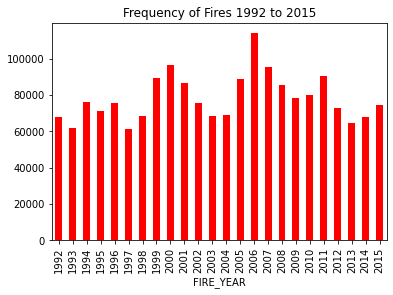

In [15]:
df = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,FIRE_SIZE,FIRE_SIZE_CLASS FROM 'Fires'", connection)
freq_df = df.groupby('FIRE_YEAR').agg('count')
freq_df['STATE'].plot(title = 'Frequency of Fires 1992 to 2015', kind="bar", color='red')

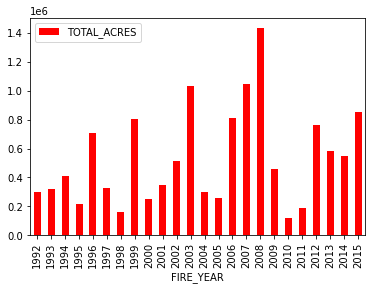

In [16]:
CA_fire_size = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS TOTAL_ACRES, State, FIRE_YEAR FROM Fires WHERE State='CA' GROUP BY FIRE_YEAR;", connection)
CA_fire_size.set_index("FIRE_YEAR").plot(kind="bar", color='red');

* **States - Size & Number of Incidents**

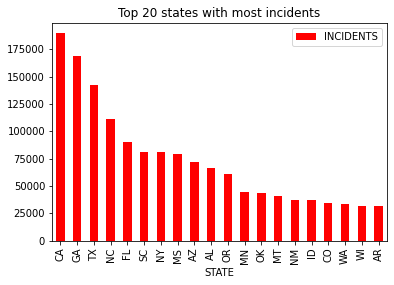

In [17]:
fire_size = pd.read_sql_query("SELECT COUNT(OBJECTID) AS INCIDENTS, STATE FROM Fires GROUP BY STATE ORDER BY INCIDENTS DESC;", connection)
fire_size = fire_size.set_index("STATE").iloc[:20].plot(kind="bar", color='red',title='Top 20 states with most incidents')
plt.savefig("acres_fire_size_per_state.png")

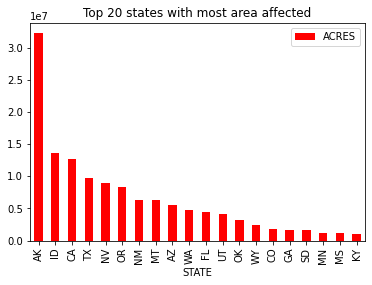

In [18]:
fire_size = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS ACRES, STATE FROM Fires GROUP BY STATE ORDER BY ACRES DESC;", connection)
fire_size = fire_size.set_index("STATE").iloc[:20].plot(kind="bar", color='red',title='Top 20 states with most area affected')
plt.savefig("acres_fire_size_per_state.png")

* **Does the season have an influence?**

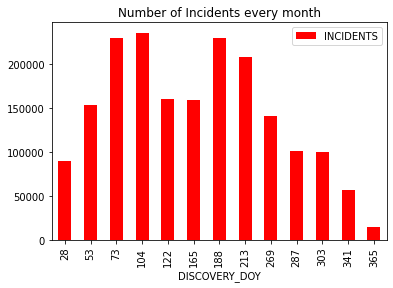

In [19]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS ACRES, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/30;", connection)
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS INCIDENTS, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/30;", connection)
df.set_index("DISCOVERY_DOY").plot(kind="bar", color='red', title='Number of Incidents every month');

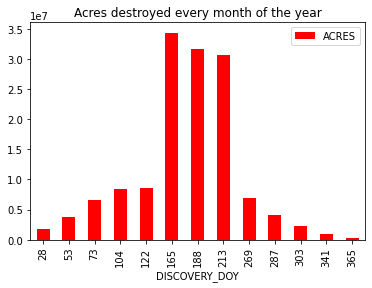

In [20]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS ACRES, DISCOVERY_DOY FROM Fires GROUP BY DISCOVERY_DOY/30;", connection)

df.set_index("DISCOVERY_DOY").plot(kind="bar", color='red', title='Acres destroyed every month of the year');

* **Duration of the fires**

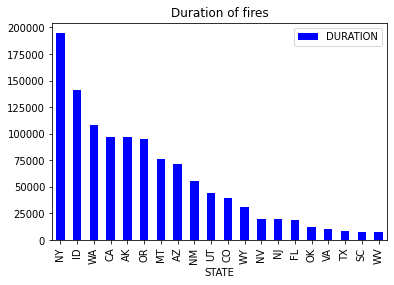

In [21]:
df = pd.read_sql_query("""
SELECT SUM(julianday(cont_date) - julianday(discovery_date)) AS DURATION, STATE FROM Fires 
WHERE CONT_DATE IS NOT NULL AND DISCOVERY_DATE IS NOT NULL AND STATE != "undefined" 
GROUP BY STATE ORDER BY DURATION DESC;
""", connection)
df.set_index("STATE").iloc[:20].plot.bar(color='blue', title='Duration of fires');

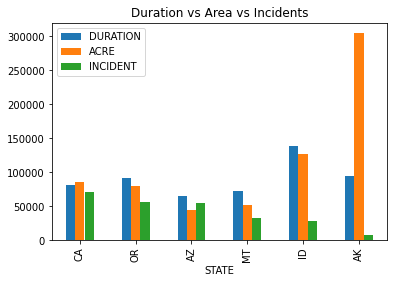

In [22]:
df = pd.read_sql_query("""
SELECT SUM(julianday(cont_date) - julianday(discovery_date)) AS DURATION, SUM(FIRE_SIZE/100) AS ACRE, 
COUNT(OBJECTID) AS INCIDENT, STATE FROM Fires 
WHERE CONT_DATE IS NOT NULL AND DISCOVERY_DATE IS NOT NULL AND STAT_CAUSE_DESCR != "Miscellaneous"
GROUP BY STATE 
HAVING ACRE > 40000 AND DURATION > 25000
ORDER BY INCIDENT DESC, ACRE DESC, DURATION DESC;
""", connection)
df.set_index("STATE").iloc[:10].plot.bar(title='Duration vs Area vs Incidents');

* **Response metric of each state**

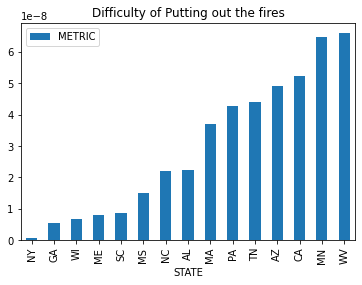

In [23]:
df = pd.read_sql_query("""
SELECT ((SUM(FIRE_SIZE)*100)/(SUM(julianday(cont_date)) - julianday(discovery_date)))/COUNT(OBJECTID) AS METRIC,
STATE FROM Fires 
WHERE CONT_DATE IS NOT NULL AND DISCOVERY_DATE IS NOT NULL 
GROUP BY STATE 
ORDER BY METRIC;
""", connection)
df.set_index("STATE").iloc[:15].plot(kind = 'bar', title='Difficulty of Putting out the fires');

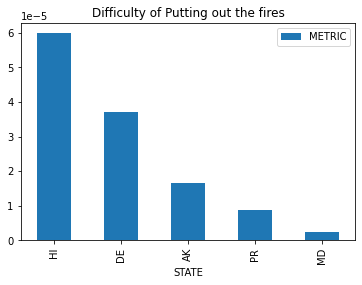

In [24]:
df = pd.read_sql_query("""
SELECT ((SUM(FIRE_SIZE)*100)/(SUM(julianday(cont_date)) - julianday(discovery_date)))/COUNT(OBJECTID) AS METRIC,
STATE FROM Fires 
WHERE CONT_DATE IS NOT NULL AND DISCOVERY_DATE IS NOT NULL 
GROUP BY STATE 
ORDER BY METRIC DESC;
""", connection)
df.set_index("STATE").iloc[:5].plot(kind = 'bar', title='Difficulty of Putting out the fires');

## Heat Map

In [50]:
df = pd.read_sql_query("SELECT LATITUDE, LONGITUDE, FIRE_SIZE, STATE FROM fires", connection)
df.head(5)

LATITUDE   LONGITUDE  FIRE_SIZE STATE
0  40.036944 -121.005833       0.10    CA
1  38.933056 -120.404444       0.25    CA
2  38.984167 -120.735556       0.10    CA
3  38.559167 -119.913333       0.10    CA
4  38.559167 -119.933056       0.10    CA

In [51]:
# Remove all wildfires in Alaska, Hawaii and Puerto Rico, because they don't fit on our map nicely.
new = df.loc[(df.loc[:,'STATE']!='AK') & (df.loc[:,'STATE']!='HI') & (df.loc[:,'STATE']!='PR')]
pd.options.mode.chained_assignment = None

# Group wildfires together that occured near to each other.
new.loc[:,'LATITUDE'] = ((new.loc[:,'LATITUDE']*10).apply(np.floor))/10
new.loc[:,'LONGITUDE'] = ((new.loc[:,'LONGITUDE']*10).apply(np.floor))/10
new.loc[:,'LL_COMBO'] = new.loc[:,'LATITUDE'].map(str) + '-' + new.loc[:,'LONGITUDE'].map(str)
grouped = new.groupby(['LL_COMBO', 'LATITUDE', 'LONGITUDE'])

# Create the datasource that is needed for the first heat maps (showing the number of wildfires per geographic location).
number_of_wf = grouped['FIRE_SIZE'].agg(['count']).reset_index()
# Create the datasource that is needed for the second heat map (showing the average size of wildfires per geographic location).
size_of_wf = grouped['FIRE_SIZE'].agg(['mean']).reset_index()

In [52]:
# Create and show the first heat map:
source = ColumnDataSource(number_of_wf)
p1 = figure(title="Number of wildfires occurring from 1992 to 2015 " + \
            "(lighter color means more wildfires)",
           toolbar_location=None, plot_width=600, plot_height=400)
p1.background_fill_color = "black"
p1.grid.grid_line_color = None
p1.axis.visible = False
color_mapper = LogColorMapper(palette=cc.fire)
glyph = p1.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'count', 'transform' : color_mapper},
          size=1)
output_notebook()
show(p1)

Loading BokehJS ...

In [53]:
# Create and show the second heat map
source = ColumnDataSource(size_of_wf)
p2 = figure(title="Average size of wildfires occurring from 1992 to 2015 " + \
            "(lighter color means bigger fire)",
           toolbar_location=None, plot_width=600, plot_height=400)
p2.background_fill_color = "black"
p2.grid.grid_line_color = None
p2.axis.visible = False
glyph = p2.circle('LONGITUDE', 'LATITUDE', source=source,
          color={'field': 'mean', 'transform' : color_mapper},
          size=1)
show(p2)

## Case Studies - NY, CA, TX

In [29]:
df = pd.read_sql_query("SELECT * FROM 'Fires'", connection)
ca_only = df[df['STATE'] == 'CA']
tx_only = df[df['STATE'] == 'TX']
ny_only = df[df['STATE'] == 'NY']

In [39]:
def size_year(state):
    ''' This function is used to visualize the size of the fires in the 
        required states over the years 1992 to 2015
        Input : State name
        Output : Visualization
    '''
    fire_year = state.groupby('FIRE_YEAR').size()
    plt.bar(range(len(fire_year)), fire_year.values, width = 0.5)
    plt.xticks(range(len(fire_year)), fire_year.index, rotation = 50)
    plt.xlabel('year')
    plt.ylabel('size (acres)')
    if len(set(state['STATE'].values)) > 1:
        plt.title("Size of Wildfires from 1992 to 2015 in US")
    elif set(state['STATE'].values) == {'CA'}:
        plt.title("Size of Wildfires from 1992 to 2015 in CA")
    elif set(state['STATE'].values) == {'TX'}:
        plt.title("Size of Wildfires from 1992 to 2015 in TX")
    elif set(state['STATE'].values) == {'NY'}:
        plt.title("Size of Wildfires from 1992 to 2015 in NY")    
    plt.show()
    
def size_doy(state):
    '''
    This function is used to plot the size of the fires in a given state
    depending on the day of the year it was discovered
    Input - State Name
    Output - Visualization
    '''
    fire_date = state.groupby('DISCOVERY_DOY').size()
    plt.scatter(fire_date.index, fire_date.values)
    plt.xlabel('Day of Year')
    plt.ylabel('size (acres)')
    if len(set(state['STATE'].values)) > 1:
        plt.title("Size of Wildfires up to Day of Year in US")
    elif set(state['STATE'].values) == {'CA'}:
        plt.title("Size of Wildfires up to Day of Year in CA")
    elif set(state['STATE'].values) == {'TX'}:
        plt.title("Size of Wildfires up to Day of Year in TX")
    elif set(state['STATE'].values) == {'NY'}:
        plt.title("Size of Wildfires up to Day of Year in NY")
    plt.show()

def cont_doy(state):
    '''
    This function is used to plot the '''
    cont_date = state.groupby('CONT_DOY').size()
    plt.scatter(cont_date.index, cont_date.values)
    plt.xlabel('Day of Year')
    plt.ylabel('Control')
    if len(set(state['STATE'].values)) > 1:
        plt.title("Control of Wildfires up to Day of Year in US")
    elif set(state['STATE'].values) == {'CA'}:
        plt.title("Control of Wildfires up to Day of Year in CA")
    elif set(state['STATE'].values) == {'TX'}:
        plt.title("Control of Wildfires up to Day of Year in TX")
    elif set(state['STATE'].values) == {'NY'}:
        plt.title("Control of Wildfires up to Day of Year in NY")
    plt.show()
    
def cause(state):
    cause = state.STAT_CAUSE_DESCR.value_counts()
    fig,ax = plt.subplots(figsize=(10,10))
    ax.pie(x=cause,labels=cause.index,rotatelabels=False, autopct='%.2f%%');
    if len(set(state['STATE'].values)) > 1:
        plt.title("Fire Cause Distribution in US")
    elif set(state['STATE'].values) == {'CA'}:
        plt.title("Fire Cause Distribution in CA")
    elif set(state['STATE'].values) == {'TX'}:
        plt.title("Fire Cause Distribution TX")
    elif set(state['STATE'].values) == {'NY'}:
        plt.title("Fire Cause Distribution in NY")
        
def number_size(state):
    fig=plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(15)
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(221)
    plt.title('Miscellaneous Caused')
    plt.xlabel('Fire Size')
    plt.grid()
    plt.ylabel('Number Wildfires')
    plt.hist(state[state['STAT_CAUSE_DESCR'] == 'Miscellaneous']['FIRE_SIZE'],bins=20,bottom=.1)
    plt.semilogy()

    plt.subplot(222)
    plt.title('Lightning Caused')
    plt.xlabel('Fire Size')
    plt.grid()
    plt.ylabel('Number Wildfires')
    plt.hist(state[state['STAT_CAUSE_DESCR'] == 'Lightning']['FIRE_SIZE'],bins=20,bottom=.1)
    plt.semilogy()

    plt.subplot(223)
    plt.title('Equipment Use Caused')
    plt.xlabel('Fire Size')
    plt.ylabel('Number Wildfires')
    plt.grid()
    plt.hist(state[state['STAT_CAUSE_DESCR'] == 'Equipment Use']['FIRE_SIZE'],bins=20,bottom=.1)
    plt.semilogy();

    plt.subplot(224)
    plt.title('Arson Caused')
    plt.xlabel('Fire Size')
    plt.ylabel('Number Wildfires')
    plt.grid()
    plt.hist(state[state['STAT_CAUSE_DESCR'] == 'Arson']['FIRE_SIZE'],bins=20,bottom=.1)
    plt.semilogy();

def heatmap(state):
    sns.heatmap(pd.crosstab(state.FIRE_YEAR, state.STAT_CAUSE_DESCR))
    if len(set(state['STATE'].values)) > 1:
        plt.title('The relation between the cause and the fire year in US')
    elif set(state['STATE'].values) == {'CA'}:
        plt.title('The relation between the cause and the fire year in CA')
    elif set(state['STATE'].values) == {'TX'}:
        plt.title('The relation between the cause and the fire year in TX')
    elif set(state['STATE'].values) == {'NY'}:
        plt.title('The relation between the cause and the fire year in NY')
    plt.show()

* **Cause**

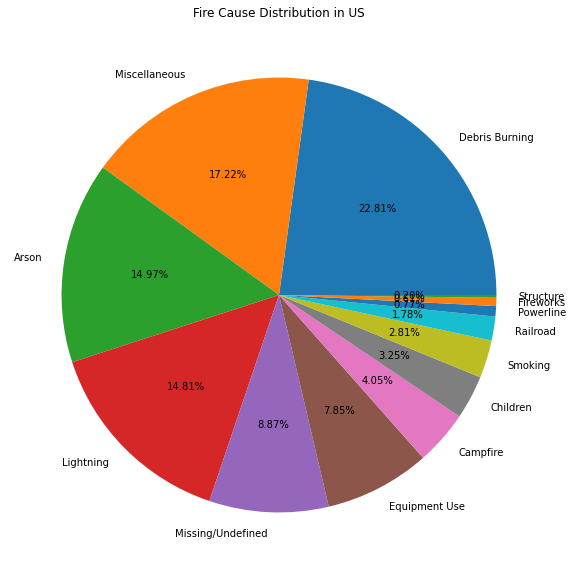

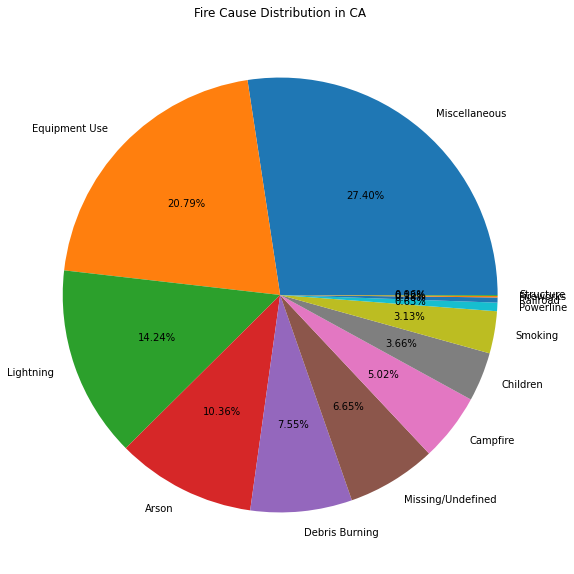

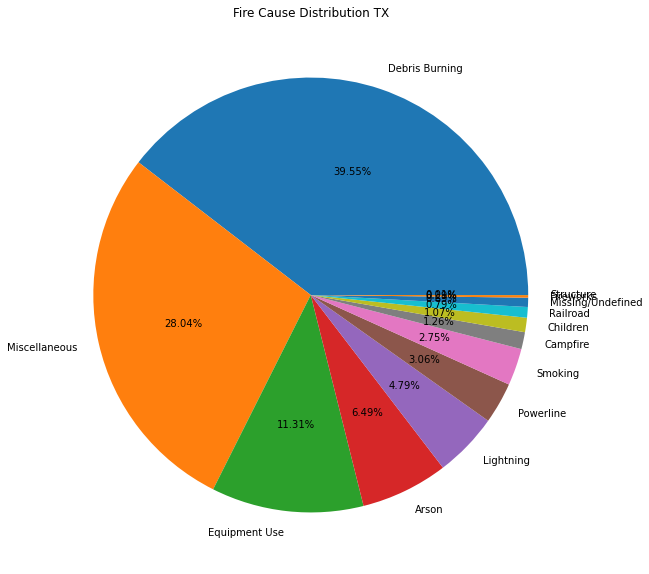

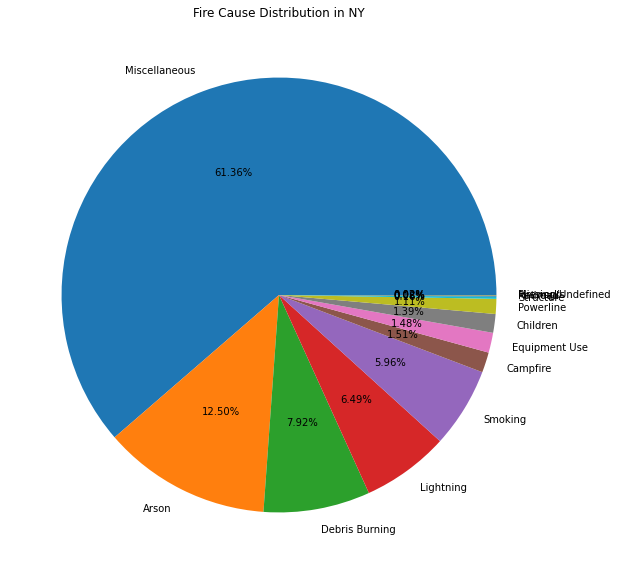

In [40]:
cause(df)
cause(ca_only)
cause(tx_only)
cause(ny_only)



* **Size - Year**

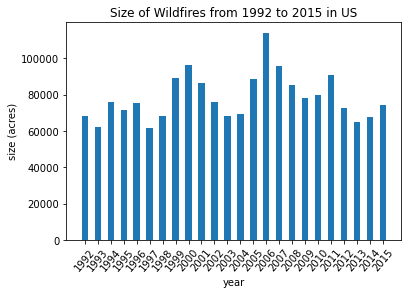

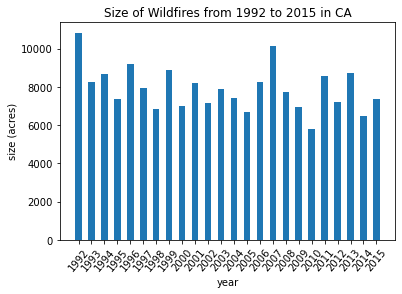

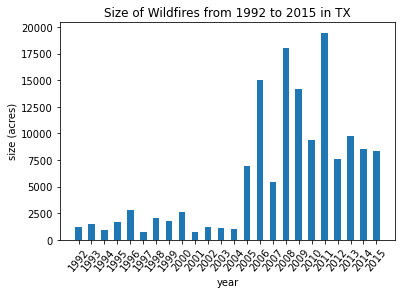

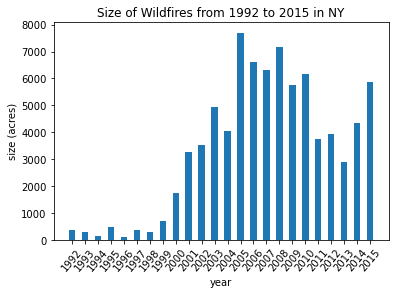

In [41]:
size_year(df)
size_year(ca_only)
size_year(tx_only)
size_year(ny_only)


* **Relation between the Cause and the Fire Year**

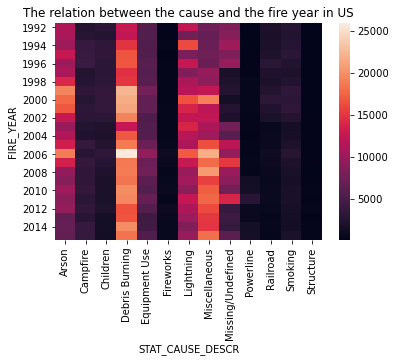

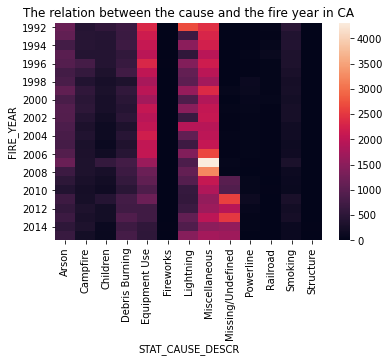

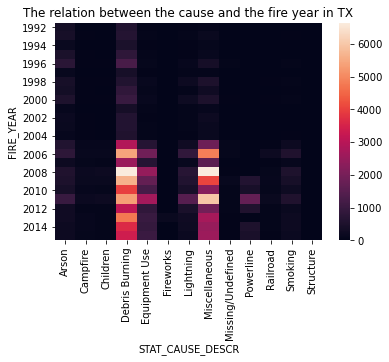

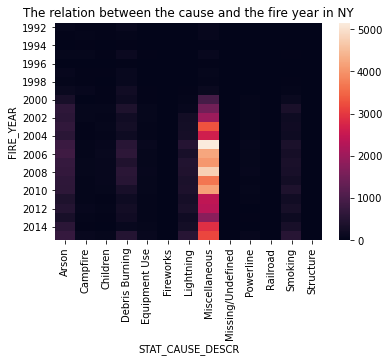

In [42]:
heatmap(df)
heatmap(ca_only)
heatmap(tx_only)
heatmap(ny_only)

### CASE Study - Differen Regions of US and there susceptability to wildfires

In [40]:
al = ['AK','AL','AR','AZ','CA','CO','CT','DC','DE','FL','GA','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','PR','RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY']
east_us = ['AL', 'TN', 'KY', 'ME','NH','NY','MA','RI','CT','NJ','DE', 'MD', 'VA', 'WV', 'VI','PA','NC','SC', 'KY', 'GA','FL']
west_us = ['CA','OR','WA', 'AK', 'NV', 'AZ', 'ID', 'MT' ]
others = []
for state in al:
    if state not in east_us:
        if state not in west_us:
            others.append(state)




north = ['AK', 'WA', 'MT','ND', 'SD', 'WY', 'OR','IL','IN', 'IA', 'ME', 'MA', 'MI','MN' 'NH','NJ','NY','OH','PA','RI','VT','WI']
south = []
for state in al:
    if state not in north:
        south.append(state)
def getEastResult(q):
    in_query = "('" + "','".join(east_us) + "')"
    return data_analyzer.read_sql(q.format(in_query), con=connection)

def getWestResult(q):
    in_query = "('" + "','".join(west_us) + "')"
    return data_analyzer.read_sql(q.format(in_query), con=connection)

def getOtherResult(q):
    in_query = "('" + "','".join(others) + "')"
    return data_analyzer.read_sql(q.format(in_query), con=connection)

def getNorthResult(q):
    in_query = "('" + "','".join(north) + "')"
    return data_analyzer.read_sql(q.format(in_query), con=connection)

def getSouthResult(q):
    in_query = "('" + "','".join(south) + "')"
    return data_analyzer.read_sql(q.format(in_query), con=connection)

def getAllResult(q):
    res = {}
    res['east'] = getEastResult(q)
    res['west'] = getWestResult(q)
    res['other'] = getOtherResult(q)
    res['north'] = getNorthResult(q)
    res['south'] = getSouthResult(q)
    return res


In [41]:
res = getAllResult("""
    SELECT STATE, SUM(FIRE_SIZE) TOTAL
    FROM FIRES 
    WHERE STATE IN {}
    GROUP BY STATE
    ORDER BY TOTAL DESC
""")

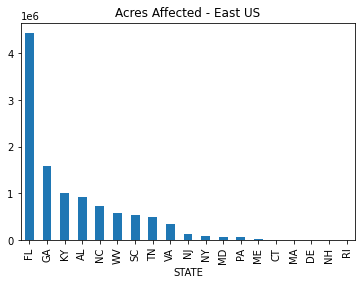

In [42]:
res['east'].set_index('STATE')['TOTAL'].plot(title = 'Acres Affected - East US', kind="bar")

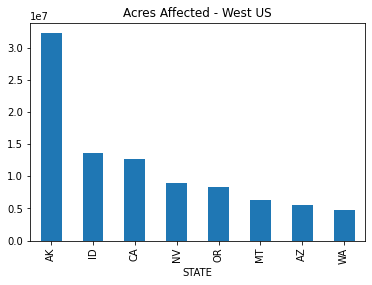

In [43]:
res['west'].set_index('STATE')['TOTAL'].plot(title = 'Acres Affected - West US', kind="bar")

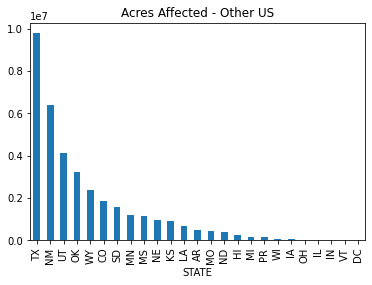

In [44]:
res['other'].set_index('STATE')['TOTAL'].plot(title = 'Acres Affected - Other US', kind="bar")

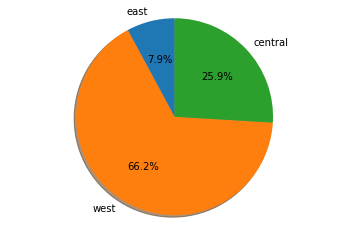

In [45]:
res['east']
labels = ['east', 'west', 'central']
regions = []
regions.append(sum(res['east']['TOTAL']))
regions.append(sum(res['west']['TOTAL']))
regions.append(sum(res['other']['TOTAL']))
fig1, ax1 = plt.subplots()
ax1.pie(regions,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

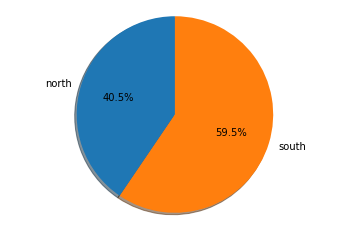

In [46]:
res['east']
labels = ['north', 'south']
regions = []
regions.append(sum(res['north']['TOTAL']))
regions.append(sum(res['south']['TOTAL']))
fig1, ax1 = plt.subplots()
ax1.pie(regions,labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [47]:
res = getAllResult("""
    SELECT STAT_CAUSE_DESCR CAUSE, COUNT(*) INCIDENT_COUNT
    FROM FIRES 
    WHERE STATE IN {}
    GROUP BY CAUSE
""")

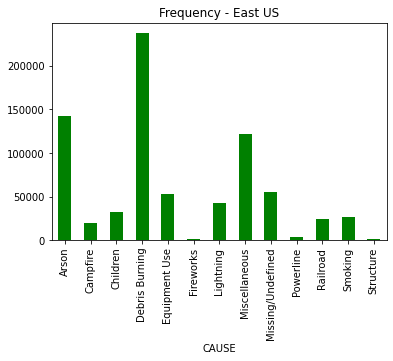

In [48]:
res['east'].set_index('CAUSE')['INCIDENT_COUNT'].plot(title = 'Frequency - East US', kind="bar", color='green')

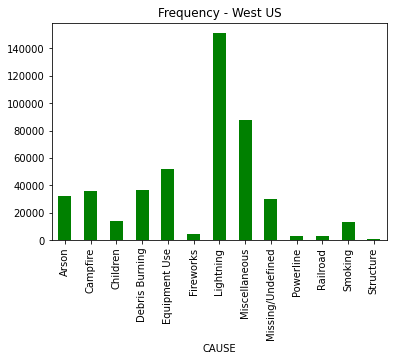

In [49]:
res['west'].set_index('CAUSE')['INCIDENT_COUNT'].plot(title = 'Frequency - West US', kind="bar", color='green')

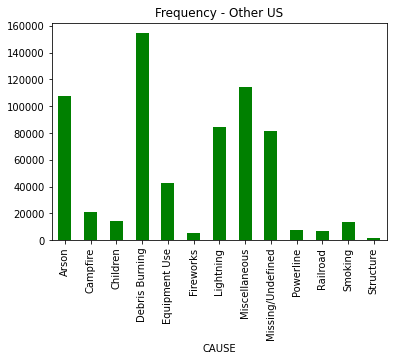

In [50]:
res['other'].set_index('CAUSE')['INCIDENT_COUNT'].plot(title = 'Frequency - Other US', kind="bar", color='green')

## Cause Prediction

In [32]:
cursor = connection.execute('select * from fires')
names = list(map(lambda x: x[0], cursor.description))
print(names)

['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM', 'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'Shape']


In [33]:
query = """
    SELECT
      latitude,
      longitude,
      fire_size as size,
      strftime('%w', discovery_date) as day_of_week,
      strftime('%m', discovery_date) as month,
      fire_year as year,
      CONT_TIME as burn_time,
      STATE as state,
      stat_cause_descr as cause
    FROM fires
    LIMIT 50000
    """
df = pd.read_sql(query, con=connection)
df = df.rename(columns={"STAT_CAUSE_DESCR": "cause"})
df['cause'] = df['cause'].map(causes_map)
df = df.dropna()
print(df.columns)
print(df.head)

Index(['LATITUDE', 'LONGITUDE', 'size', 'day_of_week', 'month', 'year',
       'burn_time', 'state', 'cause'],
      dtype='object')
<bound method NDFrame.head of         LATITUDE   LONGITUDE  size day_of_week month  year burn_time state  \
0      40.036944 -121.005833  0.10           3    02  2005      1730    CA   
1      38.933056 -120.404444  0.25           3    05  2004      1530    CA   
2      38.984167 -120.735556  0.10           1    05  2004      2024    CA   
3      38.559167 -119.913333  0.10           1    06  2004      1400    CA   
4      38.559167 -119.933056  0.10           1    06  2004      1200    CA   
...          ...         ...   ...         ...   ...   ...       ...   ...   
49995  42.825000 -120.906667  2.00           5    08  1992      1200    OR   
49996  42.943333 -121.221667  0.10           5    08  1992      2243    OR   
49997  42.986667 -120.808333  0.20           5    08  1992      0200    OR   
49998  43.188333 -121.201667  0.10           6    08  199

In [34]:
# Feature Engineering on State
d = defaultdict(int)
idx = 0
for x in df['state']:
    if x in d: continue
    d[x] = idx
    idx += 1
df['state'] = df['state'].replace(d)


def train_xgb(data):
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    xgb = XGBClassifier(n_estimators=300)
    xgb.fit(X_train, y_train)
    preds = xgb.predict(X_test)
    acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
    print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
    
def grid_search(data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    clf = xgb.XGBClassifier()
    parameters = {
#          "eta"    : [0.05, 0.15, 0.25 ] ,
         "max_depth"        : [ 3, 5, 7],
         "min_child_weight" : [ 1, 3, 5 ],
         "gamma"            : [ 0.0, 0.1, 0.2],
         "colsample_bytree" : [ 0.3, 0.5 , 0.7 ]
    }
    grid = GridSearchCV(clf,
                        parameters, n_jobs=4,
                        scoring="neg_log_loss",
                        cv=3,
                       verbose = 2)

    grid.fit(X_train, y_train)
    return grid

In [38]:
# Best Fit Random Forest
def rf_clf_best(data_frame):
    data_frame = data_frame.dropna()
    X = data_frame.drop(['cause'], axis=1).values
    Y = data_frame['cause'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0) # 80% to train; 20% test
    classifier = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
    classifier.fit(X_train, Y_train)
    score = classifier.score(X_test, Y_test) * 100
    print('Test Set Score: {} %'.format(score))
    return classifier

In [36]:
# Grid Search
def rf_gridsearch(data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    n_estimators = [200, 300]
    max_depth = [5, 15, None]
    max_features = ['auto', 'sqrt', 'log2']
    criterion = ['gini', 'entropy']

    hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              max_features = max_features, criterion = criterion)
    forest = RandomForestClassifier(random_state=42)
    gridF = GridSearchCV(forest, hyperF, cv = 5, verbose = 2, 
                      n_jobs = 4)
    bestF = gridF.fit(X_train, y_train)
    return bestF

In [39]:
# Grid Search
bestF = rf_gridsearch(df)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 16.5min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed: 23.2min finished


In [75]:
clf = rf_clf_best(df)

Test Set Score: 70.39005314348742 %


In [83]:
def confusion_matrix(clf, data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                     display_labels=data['cause'],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
confusion_matrix(clf, df)

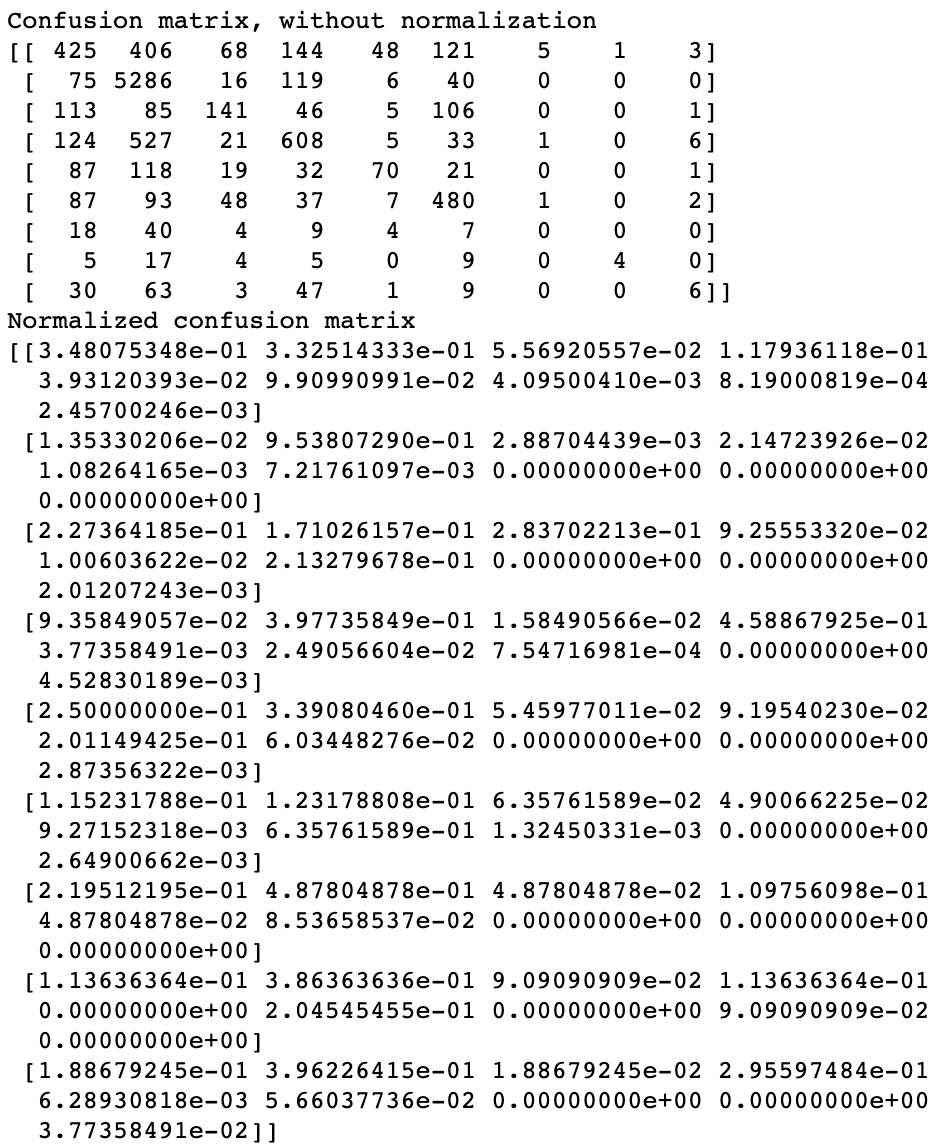

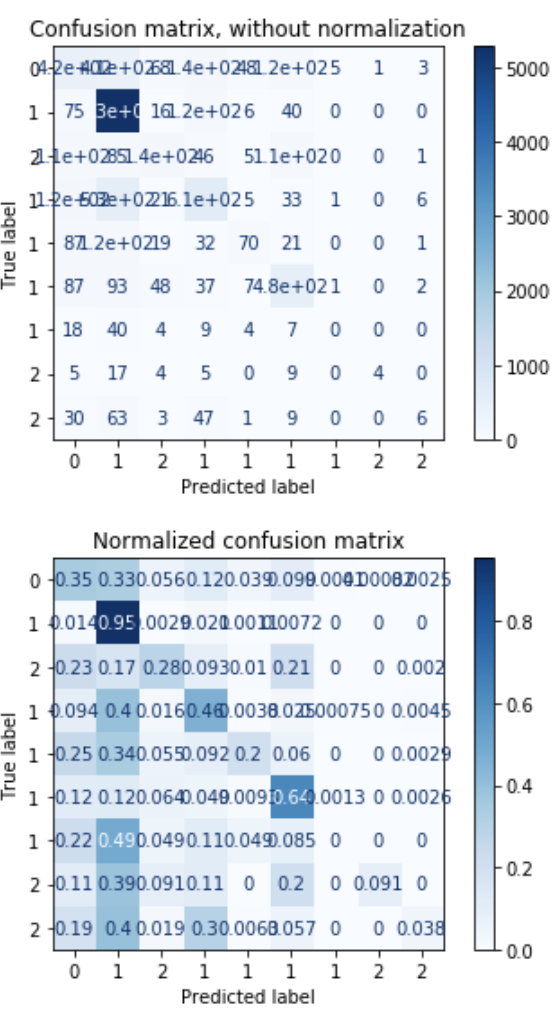

In [85]:
import seaborn as sn
def plot(clf, data):
    data = data.dropna()
    X = data.drop(['cause'], axis=1).values
    Y = data['cause'].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHI"],
                      columns = [i for i in "ABCDEFGHI"])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

plot(clf, df)

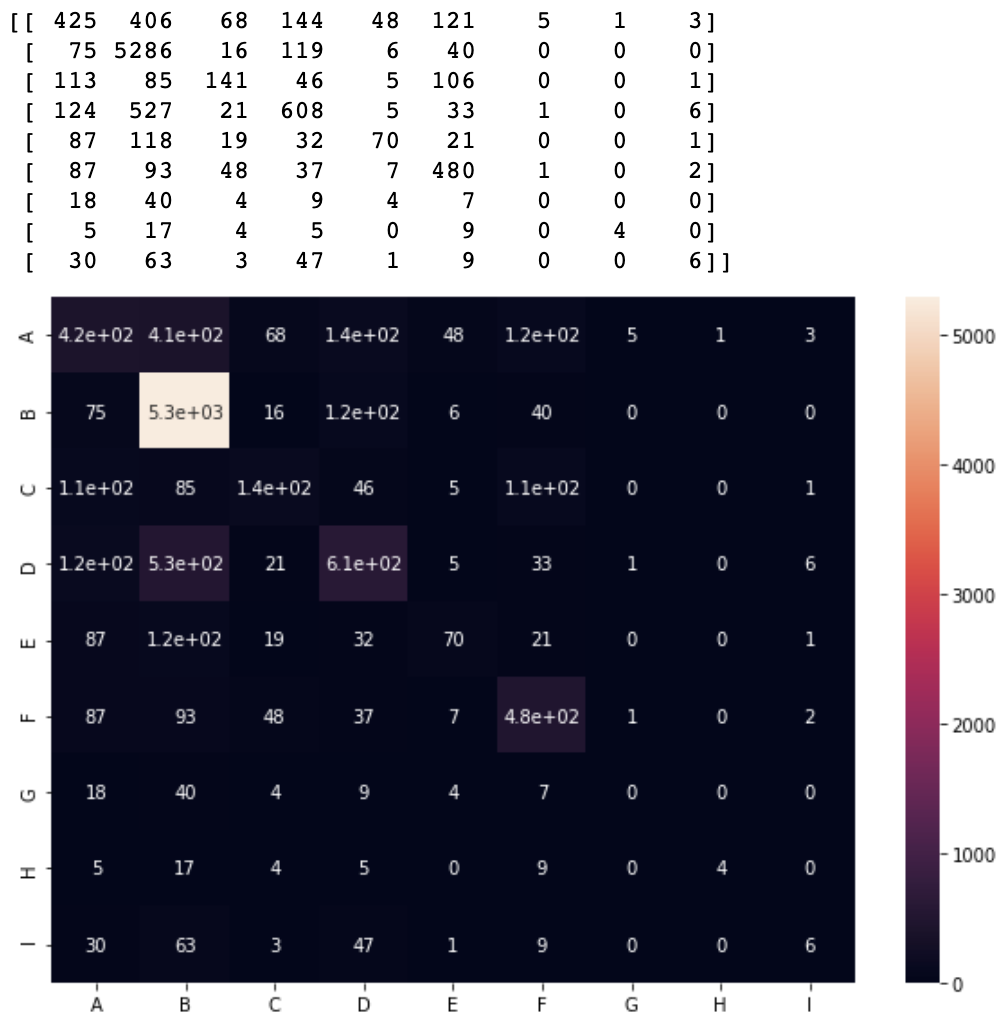